In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Preprocessing

### Import Dataset

In [11]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

gene_id  \
gene_name                     
AC073488.4  ENSG00000282222   
AC119427.1  ENSG00000282221   
MIR543      ENSG00000212040   
MADD        ENSG00000110514   
AL356737.2  ENSG00000287159   

                                                  description  \
gene_name                                                       
AC073488.4  chromodomain protein, Y chromosome-like (CDYL)...   
AC119427.1                novel transcript, antisense to LAD1   
MIR543       microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664]   
MADD        MAP kinase activating death domain [Source:HGN...   
AL356737.2                novel transcript, antisense to GPC5   

                       gene_type                   locus  RNA1_FPKM  \
gene_name                                                             
AC073488.4  processed_pseudogene       X:9410789-9411545   0.000000   
AC119427.1                lncRNA   1:201399633-201401190   0.000000   
MIR543                     miRNA  14:101031987-101032064   0.000000   
MADD              protein_coding    11:47269161-47330031   6.345943   
AL356737.2                lncRNA    13:92610646-92677725   0.000000   

            RNA102_FPKM  RNA104_FPKM  RNA108_FPKM  RNA109_FPKM  RNA110_FPKM  \
gene_name                                                                     
AC073488.4     0.000000     0.000000     0.000000     0.000000     0.000000   
AC119427.1     0.000000     0.000000     0.000000     0.000000     0.000000   
MIR543         0.000000     0.000000     0.000000     0.000000     0.962816   
MADD           8.482109    10.209322     7.143557     5.671481     7.776351   
AL356737.2     0.000000     0.000000     0.000000     0.000000     0.000000   

            ...  R_JS032_count  R_JS033_count  R_JS034_count  R_JS035_count  \
gene_name   ...                                                               
AC073488.4  ...              0              0              0              0   
AC119427.1  ...              0              0              0              0   
MIR543      ...              0              0              0              0   
MADD        ...           1187           1254           1767           1184   
AL356737.2  ...              0              0              0              0   

            R_JS036_count  R_JS037_count  R_JS038_count  R_JS039_count  \
gene_name                                                                
AC073488.4              0              0              1              0   
AC119427.1              0              0              0              0   
MIR543                  0              0              0              0   
MADD                 2418           1294           1254           1461   
AL356737.2              0              0              0              0   

            R_JS040_count  R_JS041_count  
gene_name                                 
AC073488.4              0              0  
AC119427.1              0              0  
MIR543                  0              0  
MADD                 1323           1795  
AL356737.2              0              0  

[5 rows x 390 columns]

### Check Gene Types

In [12]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [13]:
df = df[df['gene_type'] == 'lncRNA']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset06/data0.csv')

### Combine with Diagnosis

In [14]:
df = pd.read_csv('../Datasets/Dataset06/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset06/data1.csv')

df.head()

AC119427.1  AL356737.2  AC091230.1  LINC01356  AC114947.2  \
RNA1_FPKM           0.0         0.0    0.040979        0.0     0.00000   
RNA102_FPKM         0.0         0.0    0.093295        0.0     0.00000   
RNA104_FPKM         0.0         0.0    0.084011        0.0     0.00000   
RNA108_FPKM         0.0         0.0    0.041482        0.0     0.05811   
RNA109_FPKM         0.0         0.0    0.090742        0.0     0.00000   

             AC092115.2  AC233266.2  AC005288.1  AC021506.1  AC233702.7  ...  \
RNA1_FPKM           0.0    0.150459    0.000000         0.0         0.0  ...   
RNA102_FPKM         0.0    0.142714    0.223244         0.0         0.0  ...   
RNA104_FPKM         0.0    0.000000    0.000000         0.0         0.0  ...   
RNA108_FPKM         0.0    0.000000    0.095290         0.0         0.0  ...   
RNA109_FPKM         0.0    0.000000    0.094735         0.0         0.0  ...   

             AL450326.3  LINC00362  AC243960.3  ALG13-AS1  AL080248.1  \
RNA1_FPKM           0.0        0.0    0.947353   0.814793         0.0   
RNA102_FPKM         0.0        0.0    3.017052   1.545701         0.0   
RNA104_FPKM         0.0        0.0    1.071907   1.898140         0.0   
RNA108_FPKM         0.0        0.0    0.958875   0.824870         0.0   
RNA109_FPKM         0.0        0.0    2.043324   1.230309         0.0   

             LINC02806  PRKCZ-AS1  PLBD1-AS1  AL023882.1  Diagnosis  
RNA1_FPKM          0.0   2.203156   0.676363    0.043794          1  
RNA102_FPKM        0.0   1.969454   1.150103    0.623174          2  
RNA104_FPKM        0.0   1.263376   1.141618    0.571317          1  
RNA108_FPKM        0.0   2.444487   2.350972    0.398958          1  
RNA109_FPKM        0.0   1.066154   1.965337    0.396720          0  

[5 rows x 16890 columns]

### Remove Patients who hasn't Diabetic

In [15]:
df = pd.read_csv('../Datasets/Dataset06/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset06/data2.csv")
df.head()

AC119427.1  AL356737.2  AC091230.1  LINC01356  AC114947.2  \
RNA1_FPKM           0.0         0.0    0.040979        0.0     0.00000   
RNA102_FPKM         0.0         0.0    0.093295        0.0     0.00000   
RNA104_FPKM         0.0         0.0    0.084011        0.0     0.00000   
RNA108_FPKM         0.0         0.0    0.041482        0.0     0.05811   
RNA110_FPKM         0.0         0.0    0.069744        0.0     0.00000   

             AC092115.2  AC233266.2  AC005288.1  AC021506.1  AC233702.7  ...  \
RNA1_FPKM           0.0    0.150459    0.000000         0.0         0.0  ...   
RNA102_FPKM         0.0    0.142714    0.223244         0.0         0.0  ...   
RNA104_FPKM         0.0    0.000000    0.000000         0.0         0.0  ...   
RNA108_FPKM         0.0    0.000000    0.095290         0.0         0.0  ...   
RNA110_FPKM         0.0    0.000000    0.000000         0.0         0.0  ...   

             AL450326.3  LINC00362  AC243960.3  ALG13-AS1  AL080248.1  \
RNA1_FPKM           0.0        0.0    0.947353   0.814793         0.0   
RNA102_FPKM         0.0        0.0    3.017052   1.545701         0.0   
RNA104_FPKM         0.0        0.0    1.071907   1.898140         0.0   
RNA108_FPKM         0.0        0.0    0.958875   0.824870         0.0   
RNA110_FPKM         0.0        0.0    1.151675   0.385126         0.0   

             LINC02806  PRKCZ-AS1  PLBD1-AS1  AL023882.1  Diagnosis  
RNA1_FPKM          0.0   2.203156   0.676363    0.043794          0  
RNA102_FPKM        0.0   1.969454   1.150103    0.623174          1  
RNA104_FPKM        0.0   1.263376   1.141618    0.571317          0  
RNA108_FPKM        0.0   2.444487   2.350972    0.398958          0  
RNA110_FPKM        0.0   2.724196   1.061880    0.331275          0  

[5 rows x 16890 columns]

### Analyze the Dataset

In [16]:
df = pd.read_csv("../Datasets/Dataset06/data2.csv", index_col=0)
df.describe()

AC119427.1  AL356737.2  AC091230.1   LINC01356  AC114947.2  AC092115.2  \
count  143.000000       143.0  143.000000  143.000000  143.000000  143.000000   
mean     0.010032         0.0    0.060292    0.001075    0.002074    0.000922   
std      0.060147         0.0    0.051097    0.006563    0.011005    0.011028   
min      0.000000         0.0    0.000000    0.000000    0.000000    0.000000   
25%      0.000000         0.0    0.031042    0.000000    0.000000    0.000000   
50%      0.000000         0.0    0.056319    0.000000    0.000000    0.000000   
75%      0.000000         0.0    0.078496    0.000000    0.000000    0.000000   
max      0.559703         0.0    0.512660    0.064373    0.064694    0.131876   

       AC233266.2  AC005288.1  AC021506.1  AC233702.7  ...  AL450326.3  \
count  143.000000  143.000000       143.0  143.000000  ...       143.0   
mean     0.037679    0.114729         0.0    0.001427  ...         0.0   
std      0.097684    0.139811         0.0    0.017066  ...         0.0   
min      0.000000    0.000000         0.0    0.000000  ...         0.0   
25%      0.000000    0.000000         0.0    0.000000  ...         0.0   
50%      0.000000    0.051789         0.0    0.000000  ...         0.0   
75%      0.000000    0.188067         0.0    0.000000  ...         0.0   
max      0.731857    0.633105         0.0    0.204081  ...         0.0   

       LINC00362  AC243960.3   ALG13-AS1  AL080248.1   LINC02806   PRKCZ-AS1  \
count      143.0  143.000000  143.000000       143.0  143.000000  143.000000   
mean         0.0    1.276695    1.079956         0.0    0.010799    2.274657   
std          0.0    0.820637    0.767138         0.0    0.033011    0.914661   
min          0.0    0.000000    0.000000         0.0    0.000000    0.000000   
25%          0.0    0.790933    0.465624         0.0    0.000000    1.800642   
50%          0.0    1.131947    0.846091         0.0    0.000000    2.203156   
75%          0.0    1.520967    1.365818         0.0    0.000000    2.645760   
max          0.0    6.543703    4.180115         0.0    0.186160    6.037269   

        PLBD1-AS1  AL023882.1   Diagnosis  
count  143.000000  143.000000  143.000000  
mean     1.105243    0.458126    0.468531  
std      0.491923    0.278105    0.500763  
min      0.000000    0.000000    0.000000  
25%      0.764407    0.271009    0.000000  
50%      1.055809    0.413769    0.000000  
75%      1.424296    0.605510    1.000000  
max      2.476583    1.538982    1.000000  

[8 rows x 16890 columns]

In [17]:
df.dtypes

AC119427.1    float64
AL356737.2    float64
AC091230.1    float64
LINC01356     float64
AC114947.2    float64
               ...   
LINC02806     float64
PRKCZ-AS1     float64
PLBD1-AS1     float64
AL023882.1    float64
Diagnosis       int64
Length: 16890, dtype: object

In [18]:
df.isnull().sum()

AC119427.1    0
AL356737.2    0
AC091230.1    0
LINC01356     0
AC114947.2    0
             ..
LINC02806     0
PRKCZ-AS1     0
PLBD1-AS1     0
AL023882.1    0
Diagnosis     0
Length: 16890, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [19]:
df = pd.read_csv("../Datasets/Dataset06/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    1     8    11 ... 16880 16881 16884] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    1     8    11 ... 16880 16881 16884] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    1     8    11 ... 16880 168

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.53+/-0.09
1   Information Gain (Mutual info)            50            0.53+/-0.09
2   Information Gain (Mutual info)           100            0.53+/-0.09
3   Information Gain (Mutual info)           150            0.53+/-0.09
4   Information Gain (Mutual info)           200            0.53+/-0.09
5          Correlation Coefficient            25            0.53+/-0.09
6          Correlation Coefficient            50            0.53+/-0.09
7          Correlation Coefficient           100            0.53+/-0.09
8          Correlation Coefficient           150            0.53+/-0.09
9          Correlation Coefficient           200            0.53+/-0.09
10                      Chi-Square            25            0.53+/-0.09
11                      Chi-Square            50            0.53+/-0.09
12                      Chi-Square           100            0.53

### Check Feature Importance

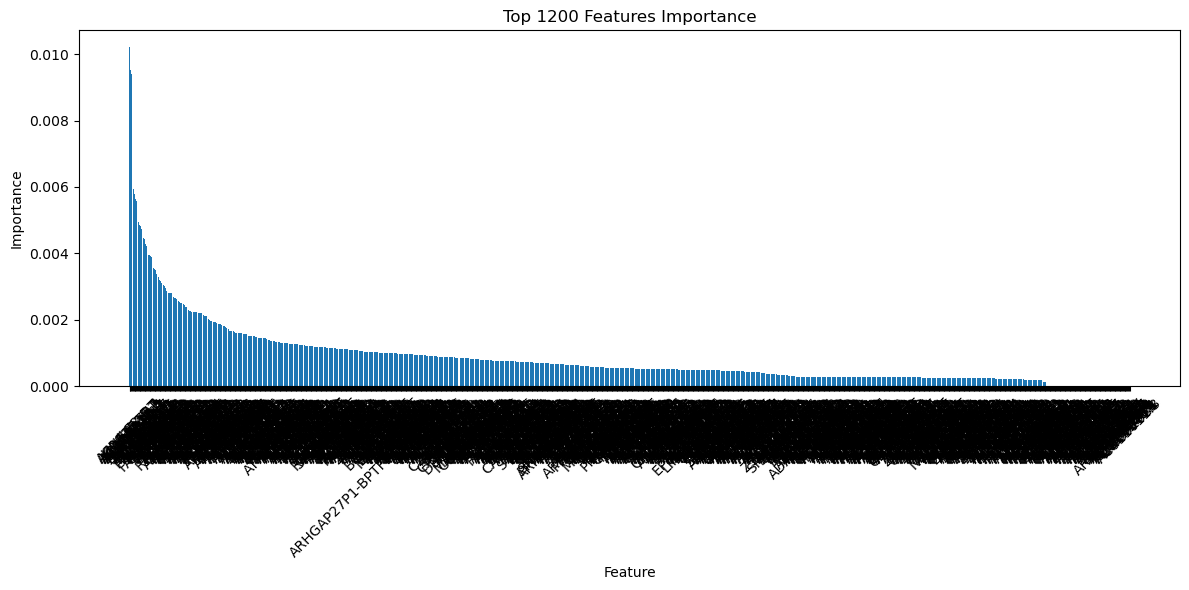

Last important feature:  1099


In [22]:
df = pd.read_csv("../Datasets/Dataset06/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [1200]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [23]:
df = pd.read_csv("../Datasets/Dataset06/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset06/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [24]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in feature_counts:
    file_path = f"../Datasets/Dataset06/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        results = results.append({"Model Name": model_name, "Feature Count": count,
                                 "CV Score (Mean +/- Std)": result}, ignore_index=True)

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset06/Feature_Select/results.csv", index=False)

C:\Users\ACER\AppData\Local\Temp\ipykernel_28796\3341198980.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model Name": model_name, "Feature Count": count,
C:\Users\ACER\AppData\Local\Temp\ipykernel_28796\3341198980.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model Name": model_name, "Feature Count": count,
C:\Users\ACER\AppData\Local\Temp\ipykernel_28796\3341198980.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model Name": model_name, "Feature Count": count,
C:\Users\ACER\AppData\Local\Temp\ipykernel_28796\3341198980.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

In [25]:
df = pd.read_csv("../Datasets/Dataset06/Feature_Select/results.csv")
df.head(10)

Model Name  Feature Count CV Score (Mean +/- Std)
0        XGBoost             91       0.8207 +/- 0.0552
1        XGBoost             86       0.8207 +/- 0.0552
2        XGBoost             88       0.8207 +/- 0.0552
3        XGBoost             87       0.8207 +/- 0.0552
4        XGBoost             90       0.8138 +/- 0.0640
5        XGBoost             89       0.8138 +/- 0.0640
6        XGBoost             95       0.8138 +/- 0.0640
7  Random Forest            114       0.8138 +/- 0.0468
8        XGBoost             82       0.8138 +/- 0.0414
9        XGBoost            108       0.8138 +/- 0.0276

### Check Distributions

In [26]:
feature_count = 91

data = pd.read_csv(
    f'../Datasets/Dataset06/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

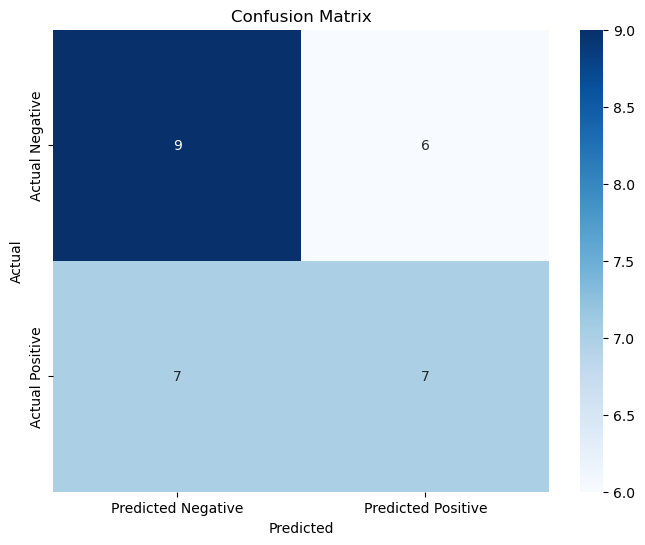

Accuracy: 0.55
Precision: 0.54
Recall (Sensitivity): 0.50
Specificity: 0.60
F1 Score: 0.52


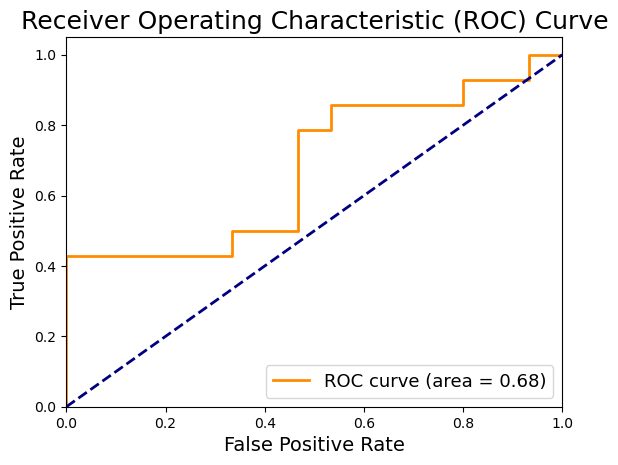

In [27]:
feature_count = 91

df = pd.read_csv(
    f'../Datasets/Dataset06/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()